### Imports

In [1]:
import sys
import os
import rasterio
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
print(sys.path[-1]) 

from Normalizacion import process_session
from Ortomosaicos import read_tif_array, show_orthomosaic
import Indices


d:\Programas Python\Trabajo Final\Trabajo-Final\src


### Carga de ortomosaicos

In [2]:
BASE_DIR = rf"D:\Programas Python\Trabajo Final\Trabajo-Final\data\Material\Ortomosaicos"

# 10 DE ENERO
MS_10ENE_RUTA = os.path.join(BASE_DIR, "10ene", "estanzuela_10ene_MS_orthophoto.tif")
RGB_10ENE_RUTA = os.path.join(BASE_DIR, "10ene", "estanzuela_10ene_rgb_orthophoto.tif")

# 17 DE ENERO
MS_17ENE_RUTA = os.path.join(BASE_DIR, "17ene", "estanzuela_17ene_MS_orthophoto.tif")
RGB_17ENE_RUTA = os.path.join(BASE_DIR, "17ene", "estanzuela_17ene_rgb_orthophoto.tif")

# 24 DE ENERO
MS_24ENE_RUTA = os.path.join(BASE_DIR, "24ene", "estanzuela_24ene_MS_orthophoto.tif")
RGB_24ENE_RUTA = os.path.join(BASE_DIR, "24ene", "estanzuela_24ene_rgb_orthophoto.tif")


# Carga de MS
MS_10ENE_DATA, MS_10ENE_PERFIL = read_tif_array(MS_10ENE_RUTA)
MS_17ENE_DATA, MS_17ENE_PERFIL = read_tif_array(MS_17ENE_RUTA)
MS_24ENE_DATA, MS_24ENE_PERFIL = read_tif_array(MS_24ENE_RUTA)

# Carga de RGB
RGB_10ENE_ARRAY, RGB_10ENE_PERFIL = read_tif_array(RGB_10ENE_RUTA)
RGB_17ENE_ARRAY, RGB_17ENE_PERFIL = read_tif_array(RGB_17ENE_RUTA)
RGB_24ENE_ARRAY, RGB_24ENE_PERFIL = read_tif_array(RGB_24ENE_RUTA)

### Elección de ortomosaico para trabajar

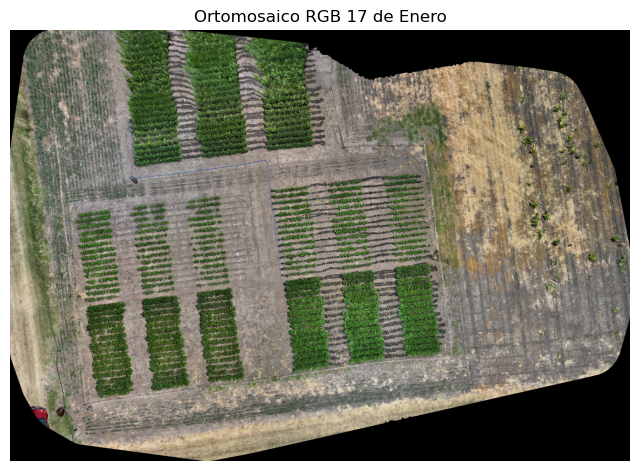

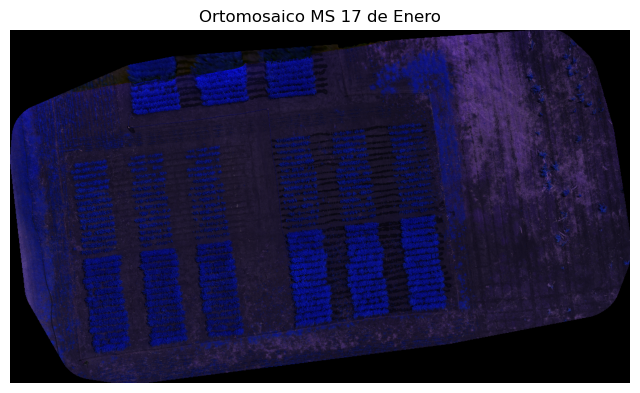

In [3]:
ortomosaico_rgb_array = RGB_17ENE_ARRAY
ortomosaico_ms_array = MS_17ENE_DATA
ortomosaico_rgb_perfil = RGB_17ENE_PERFIL
ortomosaico_ms_perfil = MS_17ENE_PERFIL

show_orthomosaic(ortomosaico_rgb_array, title="Ortomosaico RGB 17 de Enero") # type: ignore
show_orthomosaic(ortomosaico_ms_array, title="Ortomosaico MS 17 de Enero") # type: ignore

--------------------------------------------------------------------------------------------------------------------------------------

### Alineación y normalización

In [4]:
sesion_normalizada = process_session(ortomosaico_ms_array, ortomosaico_ms_perfil, # type: ignore
                                     ortomosaico_rgb_array, ortomosaico_rgb_perfil)  # type: ignore


ms_final = sesion_normalizada["ms"]
rgb_final = sesion_normalizada["rgb"]

Alineación espacial completada.
Iniciando Normalización Radiométrica
Normalización radiométrica completada.


#### Verificación

Dimensiones MS final: (5, 621, 1090)
Dimensiones RGB final (alineado): (4, 621, 1090)

Rango MS: Min=-0.0002, Max=1.0000
Rango RGB: Min=0.0000, Max=1.0000

La alineación espacial fue exitosa


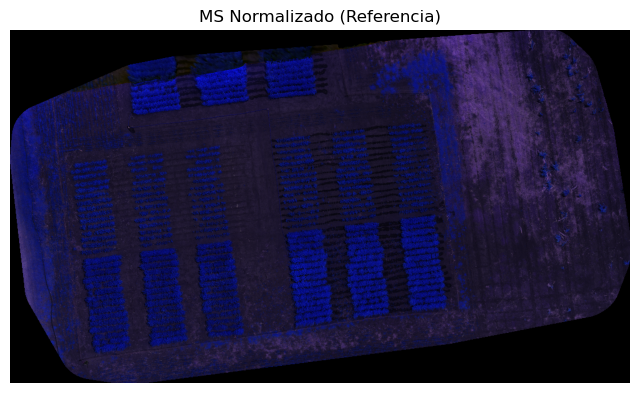

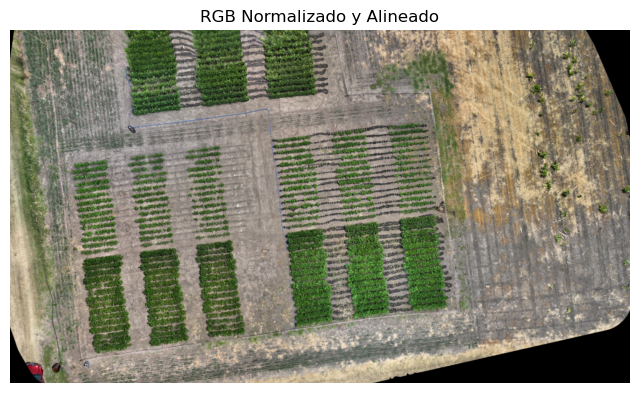

In [5]:
# Muestra las dimensiones de los arrays finales
print(f"Dimensiones MS final: {ms_final.shape}")
print(f"Dimensiones RGB final (alineado): {rgb_final.shape}")

# Verifica el rango de valores 
print(f"\nRango MS: Min={np.nanmin(ms_final):.4f}, Max={np.nanmax(ms_final):.4f}")
print(f"Rango RGB: Min={np.nanmin(rgb_final):.4f}, Max={np.nanmax(rgb_final):.4f}")

# Comprueba si las dimensiones espaciales coinciden exactamente
if ms_final.shape[1:] == rgb_final.shape[1:]:
    print("\nLa alineación espacial fue exitosa")
else:
    print("\n[ERROR] Las dimensiones espaciales no coinciden.")

# Visualiza los resultados normalizados
show_orthomosaic(ms_final, title="MS Normalizado (Referencia)")
show_orthomosaic(rgb_final, title="RGB Normalizado y Alineado")

### Cálculo de índices

#### Inicialización

In [6]:
from Indices import VegetationIndices

ms_norm = sesion_normalizada["ms"]
rgb_norm = sesion_normalizada["rgb"]

calc = VegetationIndices(ms_norm_array=ms_norm, rgb_norm_array=rgb_norm)

# Chequeo
print(f"Dimensiones MS recibidas: {calc.ms_array.shape}")
print(f"Dimensiones RGB recibidas: {calc.rgb_array.shape}") # type: ignore

Dimensiones MS recibidas: (5, 621, 1090)
Dimensiones RGB recibidas: (4, 621, 1090)


#### NDVI

Estadísticas NDVI: Min=-1.0000, Max=1.0000, Mean=0.4142


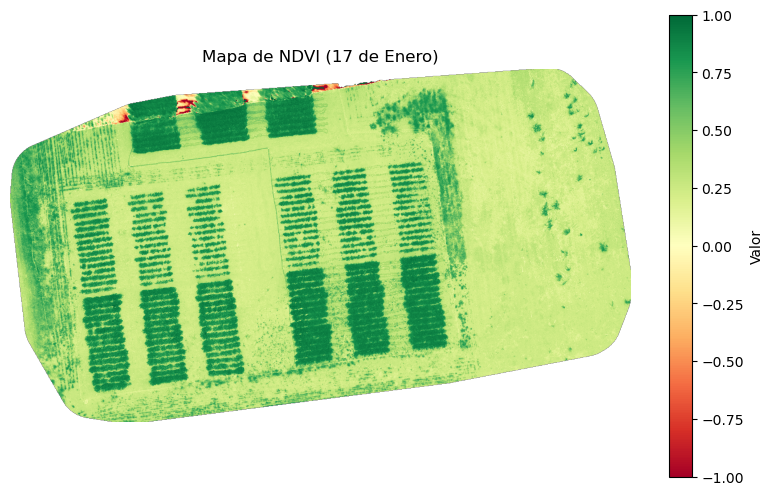

In [ ]:
# Calcula el índice NDVI
ndvi_map = calc.calculate_ndvi()

# Imprime estadísticas básicas para verificar los resultados
print(f"Estadísticas NDVI: Min={np.nanmin(ndvi_map):.4f}, Max={np.nanmax(ndvi_map):.4f}, Mean={np.nanmean(ndvi_map):.4f}")

# Muestra el mapa de calor
calc.plot_index(ndvi_map, title="Mapa de NDVI (17 de Enero)", cmap='RdYlGn')

Nota: *por el Min y el Max calculados pareciera que se activó el clip por ruido.* 